In [1]:
#packages
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf
import numpy as np
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt

In [87]:
def get_historical_Data(tickers):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()#
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i,interval = "1D", start=datetime(2018, 1, 1), end=datetime.today()).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data
ticks = ["BTC-USD",'ETH-USD','BNB-USD','SOL-USD','XRP-USD','ADA-USD','AVAX-USD','TRX-USD','DOT-USD','MATIC-USD','LINK-USD','ICP-USD','SHIB-USD','DOGE-USD','LTC-USD','BCH-USD','ETC-USD','UNI7083-USD','OP-USD','ATOM-USD','LEO-USD','WEOS-USD','NEAR-USD','XLM-USD','LDO-USD','OKB-USD','INJ-USD','IMX10603-USD','FIL-USD','APT21794-USD','XMR-USD','HBAR-USD','BXC5168-USD','KAS-USD','MNT27075-USD','TIA22861-USD','STX4847-USD','VET-USD','CRO-USD','MKR-USD','BSV-USD','GRT6719-USD','AAVE-USD','SEI-USD','RUNE-USD','HEX-USD','ALGO-USD','ORDI-USD','EGLD-USD']#,'QNT-USD','RNDR-USD','TAO22974-USD','FLOW-USD','SUI20947-USD','MINA-USD','1000SATS-USD','HNT-USD','SNX-USD','FTM-USD','ZRX-USD','ZIL-USD','YGG-USD','XEM-USD','WOO-USD','WLD-USD','WAVES-USD','TRB-USD','TIA-USD','SKL-USD','SFP-USD','SAND-USD','RIF-USD','PYTH-USD','PERP-USD','PENDLE-USD','OGN-USD','MTL-USD','MASK-USD','MANA-USD','LUNA2-USD','LRC-USD','LOOM-USD','KNC-USD','KAVA-USD','JASMY-USD','IOST-USD','GMT-USD','GAS-USD','GALA-USD','FET-USD','EOS-USD','ENS-USD','DYDX-USD','CYBER-USD','CRV-USD','CHZ-USD','CFX-USD','CAKE-USD','C98-USD','BLZ-USD','BIGTIME-USD','BEL-USD','BAND-USD','AXS-USD','AUDIO-USD','ARPA-USD','ARB-USD','ALICE-USD','PEPE-USD','AGIX-USD','FLOKI-USD'] #'STETH-USD','RETH-USD',
# ticks  = ['PEP','KO']
d = get_historical_Data(ticks)
print(d.shape)
# Most Recent Data
d

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


1 Failed download:
['TIA22861-USD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-01-01 00:00:00 -> 2024-03-10 23:19:23.565438)')



[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['STX4847-USD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-01-01 00:00:00 -> 2024-03-10 23:19:38.840087)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AAVE-USD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-01-01 00:00:00 -> 2024-03-10 23:19:57.821649)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['RUNE-USD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-01-01 00:00:00 -> 2024-03-10 23:20:09.454102)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
(2261, 49)


,BTC-USD,ETH-USD,BNB-USD,SOL-USD,XRP-USD,ADA-USD,AVAX-USD,TRX-USD,DOT-USD,MATIC-USD,...,MKR-USD,BSV-USD,GRT6719-USD,AAVE-USD,SEI-USD,RUNE-USD,HEX-USD,ALGO-USD,ORDI-USD,EGLD-USD
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,13657.200195,772.640991,8.414610,NaN,2.391030,0.728657,NaN,0.051695,NaN,NaN,...,970.085022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,14982.099609,884.443970,8.837770,NaN,2.480900,0.782587,NaN,0.078682,NaN,NaN,...,1063.069946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,15201.000000,962.719971,9.535880,NaN,3.105370,1.079660,NaN,0.094703,NaN,NaN,...,1074.530029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,15599.200195,980.921997,9.213990,NaN,3.196630,1.114120,NaN,0.207974,NaN,NaN,...,1040.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,17429.500000,997.719971,14.917200,NaN,3.048710,0.999559,NaN,0.220555,NaN,NaN,...,1096.780029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06,66106.804688,3819.226318,429.011963,130.742020,0.612253,0.733821,41.514336,0.137763,10.514227,1.117156,...,2082.189453,102.996773,0.324150,NaN,0.785684,NaN,0.009996,0.259207,75.316795,64.542313
2024-03-07,66925.484375,3874.347656,475.290649,143.977859,0.628624,0.744742,43.290005,0.137322,10.422066,1.161351,...,2103.202881,107.329079,0.346065,NaN,0.930289,NaN,0.010030,0.280696,77.244049,67.373268
2024-03-08,68300.093750,3892.061035,488.094177,145.240036,0.621955,0.724854,42.740364,0.136948,10.665132,1.127876,...,2092.292725,111.931740,0.340504,NaN,0.927307,NaN,0.011074,0.271756,77.010071,67.635284


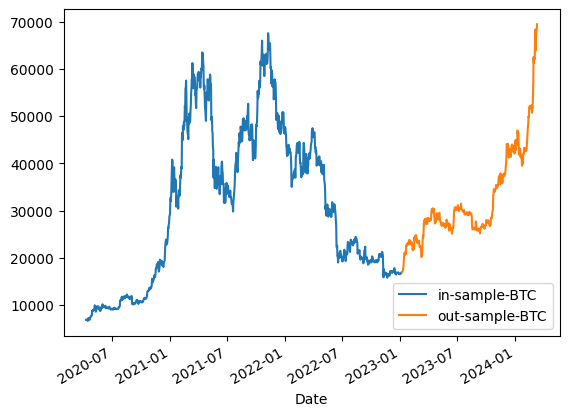

In [88]:
#data preperation
prices = d.copy()
delete = []
for i in range(len(ticks)):
    if len(prices[ticks[i]].dropna()) <= 0.6*len(prices[ticks[0]]):
        delete.append(ticks[i])
        # print(len(prices[ticks[i]]),len(prices[ticks[i]].dropna()))
prices.drop(delete,axis = 1,inplace = True)
prices = prices.dropna()
t = prices.pct_change().dropna()
t.iloc[0] = 1
# prices = t.cumsum()#normalized return
# prices = prices/prices.iloc[0] #normalization to 1 in the beginning of the period
# prices = (prices-prices.min())/(prices.max()-prices.min()) #normalization to 1 for the maximum values
split = int(len(prices)*0.7)
outsample = prices[split:]
prices = prices[:split]
prices["BTC-USD"].plot(label='in-sample-BTC')
outsample["BTC-USD"].plot(label ='out-sample-BTC')
plt.legend()
corr_matrix = prices.pct_change().corr()


In [45]:
#my  optimization method
#construction model
import pyomo.environ as pyo
model = pyo.ConcreteModel()
#parameters
N = prices.shape[1]
T = prices.shape[0]
model.N = pyo.Param(initialize = prices.shape[1]) #universe of assets #all dataset - index itself
model.T = pyo.Param(initialize = prices.shape[0]) #time duration
p       = np.array(prices).T
K = 2
#index sets
model.i = pyo.Set(initialize = np.arange(model.N))
model.j = pyo.Set(initialize = np.arange(model.N))
model.t = pyo.Set(initialize = np.arange(model.T))
# #variables
model.B0 = pyo.Var(domain = pyo.Reals)
model.B  = pyo.Var(model.j,domain = pyo.NonNegativeReals)
model.z= pyo.Var(model.i,model.j,domain = pyo.Binary)
# #objective and constraints
    # return sum(-model.B0 + np.log(P[t]) - sum(model.B[i]*np.log(p[i,t]) for i in model.i) for t in model.t)#linear
    # return sum((-model.B0 + np.log(P[t]) - sum(model.B[i]*np.log(p[i,t]) for i in model.i))**2 for t in model.t)#non linear !
def Obj(model):
    
    return sum((sum(sum((((p[i,t]) - model.B[j]*(p[j,t]) - model.B0)*(1-model.z[i,j]))**2 for j in model.j if i!=j)    for i in model.i) )   for t in model.t)
def Co1(model):
    return sum(((model.B[j]/(1+model.B[j]))*(1-model.z[i,j])) for i in model.i  for j in model.j if i!=j) <= 0.6
def Co2(model):
    return sum(model.z[i,j]   for i in model.i for j in model.j if i!=j) == (N**2)-N-1
# def Co3(model,t):
#     correlation of i,j >= 0.8

      
model.Obj = pyo.Objective(rule = Obj,sense = pyo.minimize)
model.Co1 = pyo.Constraint(rule = Co1)
model.Co2 = pyo.Constraint(rule = Co2)
# model.Co3 = pyo.Constraint(model.t,rule = Co3)


In [ ]:
#GA
import random
import time
from statsmodels.tsa.stattools import adfuller
N = len(ticks)
K_max = 4
K_min = 2
min_unit =-20
max_unit = 20
P = 50
CR = 0.7
MR = 0.7
mr = 1/N
mut_change   = 0.05
cr_change    = 0.01
current_best = 999999999999
best_LB      = 999999999999
p            = np.array(prices).T
print('initializing the model...')
def initialize(P):
    chromosome = []
    for p in range(int(P)):
        chromosome.append(np.array([random.uniform(min_unit, max_unit) for _ in range(N)]))
        # chromosome.append(temp/sum(temp))
    return np.array(chromosome)
def crossover(chromosome,f='None'):
    offspring = []
    rand_pair = [random.sample(range(0,len(chromosome)),2)   for i in range(int(P*CR))]
    for pair in rand_pair:
        off = [0] * N
        for s in range(N): 
            mean = (chromosome[pair[0]][s]+chromosome[pair[1]][s])/2
            off[s] = mean+random.normalvariate(0,cr_change)
        offspring.append(off)
    return offspring 
def mutation(chromosome,f='None'):
    mutation = mr
    # if repeat>=5 and random.random()<=0.8:
    #     mutation = mr*2
    offspring = []        
    rand_pair = random.sample(range(0,len(chromosome)),int(P*MR))
    for pair in rand_pair:
        off = chromosome[pair]
        temp =  [off[elm]+random.normalvariate(0, mut_change)   if random.random()<=mutation else  off[elm] for elm in range(len(off))  ]  
        # temp =np.array(temp)/sum(temp)
        offspring.append(temp)
    return offspring 
def selection(chromosome,f):
    index = np.argsort(f)[:P]
    return chromosome[index],np.sort(f)[:P]
def decode(chromosome):
    decoded = [0] * len(chromosome)
    for i in range(len(chromosome)):
        decoded[i] = np.argsort(chromosome[i])[::-1][:K]
    return decoded
def fitness_adfuller(chromosome):
    #sum(chromosome@p)**2
    f = [0]*len(chromosome)
    for i in range(len(chromosome)):
        diff = chromosome[i]@p
        f[i] = adfuller(diff)[0]
    return f
def fitness_rmse(chromosome):
    squared_error = (chromosome@p)**2
    # std = [0] * len(squared_error)
    f = np.sum(squared_error,axis=1)
    # for i in range(len(squared_error)):
    #     std[i] = np.std(squared_error[i])
    # f-=std
    return f
def repair(chromosome):
    for i in range(len(chromosome)):
        index = np.argsort(chromosome[i])[:N-K]
        chromosome[i][index]=0
        chromosome[i] = chromosome[i]/sum(chromosome[i])
    return chromosome

initial=1
GA,LB,last_loop = 0,False,False
timer = 120
s = time.time() #starting time
# print('Solving process has started...')

while True:
    if time.time()-s >=timer:
        last_loop = True
        print('Last loop')
    if initial==1:
        chromosome = initialize(P)
        initial = 0

    C = np.array(crossover(chromosome),dtype=object)
    M = np.array(mutation(chromosome),dtype=object)
    MC = np.vstack((C,M))
    chromosome = np.vstack((chromosome,MC))
#     chromosome = repair(chromosome)

    f = fitness_rmse(chromosome)
    chromosome,f = selection(chromosome,f)

    if min(f) < current_best:
        current_best = min(f)
#         repeat = 0

    print(f'best solution found:',min(f))#time
    if last_loop==True:
        break
'Best solution found:',min(f)

In [ ]:
#results for GA
sol = chromosome[np.where(f == min(f))][0]
pd.Series(list(sol@p)).plot()

min(f),adfuller(list(sol@p))[0],sol

In [21]:
#Evolutionary multi-objective optimization for multivariate pairs trading optimization model
#my  optimization method
#construction model
import pyomo.environ as pyo
from statsmodels.tsa.stattools import adfuller
model = pyo.ConcreteModel()
#parameters
N = prices.shape[1]
T = prices.shape[0]
model.N = pyo.Param(initialize = prices.shape[1]) #universe of assets #all dataset - index itself
model.T = pyo.Param(initialize = prices.shape[0]) #time duration
p       = np.array(prices).T
K_max = 2
K_min = 2
TC = 0 #TARGET COIN
c     = 100000#p[TC,-1]
#index sets
model.i = pyo.Set(initialize = np.arange(model.N))
model.j = pyo.Set(initialize = np.arange(model.N))
model.t = pyo.Set(initialize = np.arange(model.T))
# #variables
# model.w   = pyo.Var(model.i,domain = pyo.NonNegativeReals)
# model.z   = pyo.Var(model.i,domain = pyo.Binary)
model.d   = pyo.Var(model.t,domain = pyo.NonNegativeReals)
model.u   = pyo.Var(model.t,domain = pyo.NonNegativeReals)
model.wl  = pyo.Var(model.i,domain = pyo.NonNegativeReals)
model.ws  = pyo.Var(model.i,domain = pyo.NonNegativeReals)
model.zl  = pyo.Var(model.i,domain = pyo.Binary)
model.zs  = pyo.Var(model.i,domain = pyo.Binary)
def Obj(model):
    # return (sum(model.d[t]   for t in model.t))#/(model.var) #non-linear|variance
    # return sum(((sum(p[i,t]*model.wl[i]  for i in model.i))  -  (sum(p[i,t]*model.ws[i] for i in model.i)))**2 for t in model.t) #non-linear
    return sum(model.d[t] + model.u[t] for t in model.t)# - ((1/T)*sum(model.var1[t] + model.var2[t]  for t in model.t))#linear
    # return sum(( (p[0,t]) - sum(model.w[i]*(p[i,t]) for i in model.i))**2 for t in model.t)#cointegrated index
def Co1A(model):
    # return sum(model.zl[i] + model.zs[i] for i in model.i) == K_max
    return sum(model.zl[i] for i in model.i) == 1
def Co1B(model):
#     # return sum(model.z[i] for i in model.i) == K_max
    return sum(model.zs[i] for i in model.i) == 1
# def Co2(model):
#     return sum(model.zl[i]+model.zs[i] for i in model.i) >= K_min
def Co3(model,i):
    return model.zs[i] + model.zl[i] <= 1
def Co4(model,i):
    # return p[i,-1]*model.w[i] <= c*model.z[i]
    return model.wl[i] <= (100*model.zl[i])
def Co5(model,i):
    return model.ws[i] <= (100*model.zs[i])
# def Co6(model):
    # return sum(model.w[i]*p[i,-1] for i in model.i) <= c
    # return sum(model.ws[i]*p[i,-1] + model.wl[i]*p[i,-1] for i in model.i) <= c
def Co7(model,i):
    # return model.w[i]*p[i,-1] >= 0.01 * c * model.z[i]
    return model.wl[i] >= (0.01*model.zl[i])
def Co8(model,i):
    return model.ws[i] >= (0.01*model.zs[i])
    
def Co9(model,t): #linear ablsolute value
#     return model.d[t] - model.u[t] ==  (c*(p[i,t]/p[i,-1])) - (sum(p[i,t]*model.w[i]  for i in model.i)) #kernel index tracking
#     return (-model.w0 + np.log(p[0,t]) - sum(model.w[i]*np.log(p[i,t]) for i in model.i)) >=0 #positive cointegrated value
    # return model.d[t] - model.u[t] == (p[0,t]) - sum((p[i,t])*model.w[i] for i in model.i) 
    return model.d[t] - model.u[t] == (sum(p[i,t]*model.wl[i]  for i in model.i))  -  (sum(p[i,t]*model.ws[i] for i in model.i))
# def Co10(model,t):
#     return model.d[t] == ((sum(p[i,t]*model.wl[i]  for i in model.i))  -  (sum(p[i,t]*model.ws[i] for i in model.i)))**2
# def Co11(model): 
#     return (1/(T-1))*sum(((model.d[t])-(sum(model.d[t] for t in model.t)/T))**2 for t in model.t) <= 10.00
# def Co12(model): #MAD
#     return (1/T)*sum(model.var1[t] + model.var2[t]  for t in model.t) <= 5000
    # return (1/T)*(sum((model.d[t]-model.u[t])-(sum(model.d[t]-model.u[t]    for t in model.t)/T)  for t in model.t)) >= 1
# def Co13(model,t): #Linear mean absolute deviation
#     return model.var1[t] - model.var2[t] == (model.d[t]-model.u[t])-(sum(model.d[t0]-model.u[t0]    for t0 in model.t)/T)
# def Co14(model):#don't pick BTC itself
#     return model.w[TC] == 0
# def Co15(model):#least correlation
# def Co15(model):
#     return sum(corr[i,j] for i in model.i for j in model.j) >= 2

model.Obj = pyo.Objective(rule = Obj,sense = pyo.minimize)
model.Co1A = pyo.Constraint(rule = Co1A) #cardinality constraint
model.Co1B = pyo.Constraint(rule = Co1B) #cardinality constraint
# model.Co2 = pyo.Constraint(rule = Co2) #cardinality constraint
model.Co3 = pyo.Constraint(model.i,rule = Co3) #either long or short position
model.Co4 = pyo.Constraint(model.i,rule = Co4) #upper bound w
model.Co5 = pyo.Constraint(model.i,rule = Co5) #upper bound w
# model.Co6 = pyo.Constraint(rule = Co6) #budget constraint
model.Co7 = pyo.Constraint(model.i,rule = Co7) #lower bound w
model.Co8 = pyo.Constraint(model.i,rule = Co8) #lower bound w
model.Co9 = pyo.Constraint(model.t,rule = Co9) # absolute values
# model.Co10 = pyo.Constraint(model.t,rule = Co10)
# model.Co11 = pyo.Constraint(rule = Co11) #variance
# model.Co12 = pyo.Constraint(rule = Co12) #linear mean absolute deviation
# model.Co13 = pyo.Constraint(model.t,rule = Co13) #linear mean absolute deviation
# model.Co14 = pyo.Constraint(rule = Co14) #linear mean absolute deviation



In [ ]:
solver = pyo.SolverFactory('gams')
results = solver.solve(model,tee=True,solver = 'cplex',add_options =['GAMS_MODEL.resLim = 60;'])
model.display()
#couenne,scip,bonmin

In [90]:
#Top cointegrated points pairs
#NEDL excel
from statsmodels.tsa.stattools import adfuller,coint
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import random
n = 20*20 #check pairs
pairs = corr_matrix.unstack().sort_values(ascending=False)[len(ticks):len(ticks)+n].keys()
onep = {}
fivep = {}
ind = 0
checked = {}
counter = 0
acceptable_period = 700
std_period = 10
for p in set(pairs): #picking top correlated pairs
    counter +=1
    print(f'{counter} number of pairs analyzed')
    # X,Y = random.choice(ticks),random.choice(ticks)
    X,Y = p[0],p[1]
    # if (X,Y) in checked or (Y,X) in checked:
    if False: #len(prices[X].dropna())<=acceptable_period or len(prices[Y].dropna())<=acceptable_period:
        pass
    else:
        print(X,Y)
        checked[random.random()] = X,Y
        df = pd.DataFrame(prices[X])
        df[Y] = prices[Y]
        df.dropna(subset=[X, Y], inplace=True)
        slope, intercept = np.polyfit(df[X],df[Y], 1)
        coint = slope*df[X] + intercept
        coint_diff = df[Y] - coint
        result = adfuller(coint_diff)
        if result[0] <= result[4]['1%']:
            # print(df[Y].pct_change().rolling(std_period).std())
            ratio = (df[Y].pct_change().rolling(std_period).std().mean())/(df[X].pct_change().rolling(std_period).std().mean())
            onep[random.random()] = X,Y ,result[0],result[4]['1%'],ratio
        # if result[0] >= result[4]['1%'] and result[0]<=result[4]['5%']:
        #     fivep[random.random()] = X,Y,result[0],result[4]['5%']
'onep',onep,'fivep',fivep
#high cointegrated pairs: QNT-FIL, 

1 number of pairs analyzed
BCH-USD MATIC-USD
2 number of pairs analyzed
MKR-USD BCH-USD
3 number of pairs analyzed
ADA-USD ETC-USD
4 number of pairs analyzed
LTC-USD ATOM-USD
5 number of pairs analyzed
BTC-USD OKB-USD
6 number of pairs analyzed
BSV-USD XRP-USD
7 number of pairs analyzed
MKR-USD TRX-USD
8 number of pairs analyzed
ETH-USD ATOM-USD
9 number of pairs analyzed
TRX-USD ADA-USD
10 number of pairs analyzed
VET-USD ATOM-USD
11 number of pairs analyzed
LTC-USD ALGO-USD
12 number of pairs analyzed
HBAR-USD BTC-USD
13 number of pairs analyzed
BNB-USD TRX-USD
14 number of pairs analyzed
XLM-USD VET-USD
15 number of pairs analyzed
OKB-USD BNB-USD
16 number of pairs analyzed
VET-USD ALGO-USD
17 number of pairs analyzed
HBAR-USD ETC-USD
18 number of pairs analyzed
TRX-USD LINK-USD
19 number of pairs analyzed
BTC-USD TRX-USD
20 number of pairs analyzed
MATIC-USD ADA-USD
21 number of pairs analyzed
ATOM-USD ALGO-USD
22 number of pairs analyzed
BSV-USD MKR-USD
23 number of pairs analyzed

('onep',
 {0.7384258648185168: ('ETH-USD',
   'ATOM-USD',
   -3.936465369111402,
   -3.4370266558635914,
   1.4216494883692288),
  0.1394801621544478: ('BNB-USD',
   'TRX-USD',
   -3.4937086029767768,
   -3.4370062675076807,
   0.9528228971876935),
  0.6785635068779448: ('VET-USD',
   'ALGO-USD',
   -3.589966337333966,
   -3.4369325637409154,
   0.9770866941848012),
  0.24758425499396264: ('HBAR-USD',
   'ETC-USD',
   -3.562065291756121,
   -3.4370471695043037,
   0.9902323042178325),
  0.08617521820771412: ('ETC-USD',
   'XRP-USD',
   -4.594689400226332,
   -3.4370403176323214,
   0.9588641185471739),
  0.7347630096974089: ('HBAR-USD',
   'XRP-USD',
   -5.668354312136123,
   -3.4370471695043037,
   0.949498225540769),
  0.6725750019000715: ('ADA-USD',
   'VET-USD',
   -4.245690967093289,
   -3.437054035425408,
   1.1412068677018825),
  0.4673174032281482: ('XLM-USD',
   'LINK-USD',
   -3.5348358205310446,
   -3.4370266558635914,
   1.1495732881335976),
  0.406140335586614: ('XRP-USD',

In [101]:
#OLS 
X = 'ALGO-USD'
Y = 'ETH-USD'
df = pd.DataFrame(prices[X])
df[Y] = prices[Y]
df.dropna(subset=[X, Y], inplace=True)
slope, intercept = np.polyfit(df[X],df[Y], 1)#polyfit(X,Y,1) #normal cointegration
print('slope:',slope,'intercept:',intercept) #normal cointegration
coint = slope*df[X] + intercept #normal cointegration
coint_diff = df[Y] - coint #normal cointegration
result = adfuller(coint_diff)
result

slope: 1979.4616522373478 intercept: 385.58639560066985


(-2.417836451697723,
 0.13676535425654085,
 16,
 984,
 {'1%': -3.437013049776705,
  '5%': -2.864481711583566,
  '10%': -2.5683363157264196},
 11935.851395170164)

<AxesSubplot: xlabel='Date'>

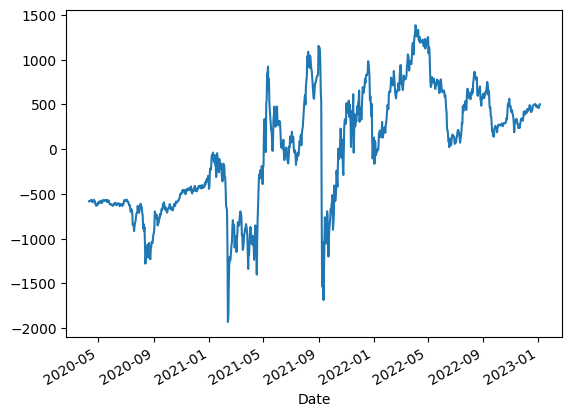

In [102]:
#real spread
spread = coint_diff
spread.plot()

In [ ]:
#Support Vector Machine


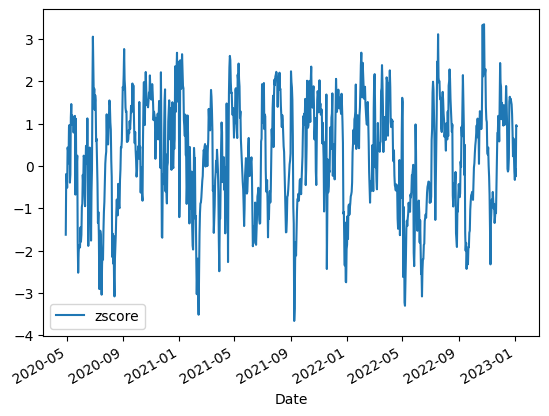

In [103]:
#in-sample result for paper
ticker = prices.columns
# long,short = [0] * N,[0] * N

# for i in model.i:
#     if model.wl[i].value>0:
#         print(ticker[i],'long',model.wl[i].value)
#         long[i] = model.wl[i].value
#     if model.ws[i].value>0:
#         print(ticker[i],'short',model.ws[i].value)
#         short[i]= model.ws[i].value
# long,short = np.array(long),np.array(short)
# long.shape,p.shape
# long_portfolio  = pd.Series(long@p)
# short_portfolio = pd.Series(short@p)
# (long_portfolio).plot(label = 'Portfolio')
# pd.Series((p[TC])).plot(label = 'Target coin')
# spread = long_portfolio - pd.Series(p[TC])
# spread = long_portfolio - short_portfolio
# (spread).plot(label = 'spread')
# mean = (p[TC] - long_portfolio).mean()
# pd.Series([mean] * len(long_portfolio)).plot()



#using Z-score
window = 20
spread_mean = spread.rolling(window = window).mean()
spread_std  = spread.rolling(window  = window).std()
zscore      = (spread - spread_mean)/ spread_std
zscore.plot(label='zscore')


plt.legend()
# adfuller(long_portfolio-short_portfolio)

<AxesSubplot: xlabel='Date'>

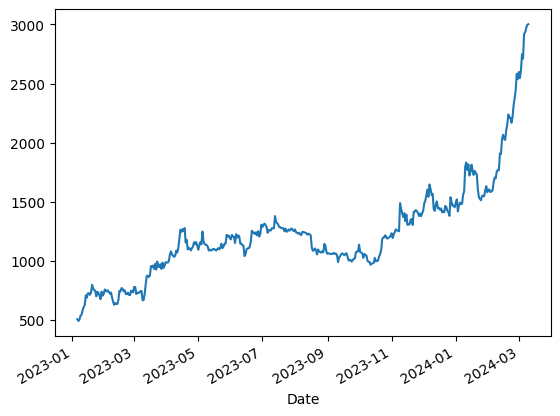

In [104]:
#real out sample spread
spread_o = outsample[Y] - (intercept + slope * outsample[X])
spread_o.plot()

2.390871695714987

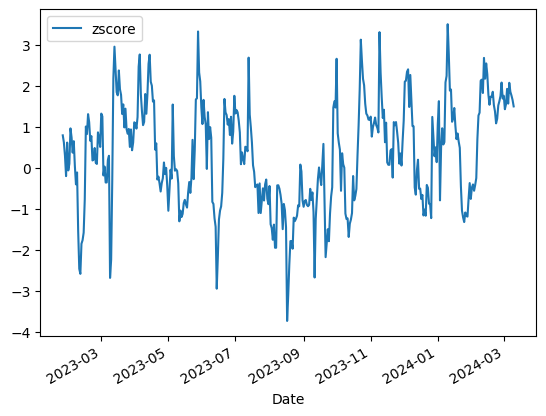

In [109]:
#out-sample results for paper
# o = np.array(outsample).T
# long_portfolio = pd.Series(long@o)
# short_portfolio= pd.Series(short@o)
# long_portfolio.plot(label = 'Long')
# pd.Series(o[TC]).plot(label = 'Target coin')
# spread_o = long_portfolio - pd.Series(o[TC])




window = 20
spread_mean_o = spread_o.rolling(window = window).mean()
spread_std_o  = spread_o.rolling(window  = window).std()
zscore_o      = (spread_o - spread_mean_o)/ spread_std_o
zscore_o.plot(label='zscore')

# (.plot(label = 'spread')
# pd.Series([mean] * len(long_portfolio)).plot()
plt.legend()
adfuller(spread_o)[0]

weights: 0.5
sell ETH-USD 1627.1181640625 buy ALGO-USD 0.23966699838638306
ETH-USD 1598.156494140625 ALGO-USD 0.2547279894351959
gain-loss 0.0403203435086843
sell ETH-USD 1691.8194580078125 buy ALGO-USD 0.2735140025615692
ETH-USD 1658.036376953125 ALGO-USD 0.278344988822937
gain-loss 0.018815577944760298
buy ETH-USD 1643.231689453125 short ALGO-USD 0.27132299542427063
ETH-USD 1795.7081298828125 ALGO-USD 0.21409499645233154
gain-loss 0.15185631441785252
buy ETH-USD 1848.6031494140625 short ALGO-USD 0.16516900062561035
ETH-USD 1821.859619140625 ALGO-USD 0.17232300341129303
gain-loss -0.028890057412267134
sell ETH-USD 1828.689697265625 buy ALGO-USD 0.15005099773406982
ETH-USD 1862.201416015625 ALGO-USD 0.14821699261665344
gain-loss -0.015274040615440854
buy ETH-USD 1876.0596923828125 short ALGO-USD 0.13280199468135834
ETH-USD 1852.227294921875 ALGO-USD 0.12025800347328186
gain-loss 0.040876456989576426
sell ETH-USD 1881.06884765625 buy ALGO-USD 0.111394003033638
ETH-USD 1850.75341796875 A

<AxesSubplot: >

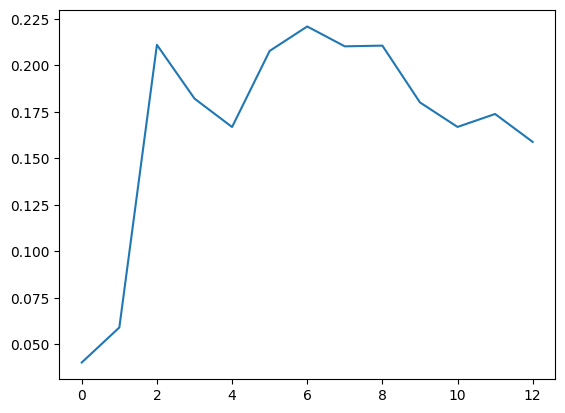

In [110]:
#trade simulation on out-sample
# Y = pd.Series(o[TC])
# portfolio = long_portfolio
position = 0
treshold_up = 2
treshold_down = -2
zscore_o = zscore_o.dropna()
# index = zscore_o.head(1).index[0]
buy = np.where(long >0)[0]
weight = 1/(len(buy)+1)
print('weights:',weight)
history = []
# for i in range(index,len(zscore_o)):
for i in range(len(zscore_o)):
    # print(zscore_o.iloc[i])
    if position != 0:
        if previous*zscore_o.iloc[i] <= 0:
            temp = 0
            # for j in range(len(X)):
            #     print(ticker[buy[j]],o[[buy[j]],i])
            #     temp+= weight*(-position*((o[[buy[j]],i]/X[j])-1))
            # print(ticker[TC],o[TC,i],temp)#,position*((o[TC,i]/y)-1)
            # gain_loss = position*((o[TC,i]/y)-1)*(weight)  + (temp)
            #=====================================================================
            print(Y,outsample[Y].iloc[i],X,outsample[X].iloc[i])
            gain_loss = (0.5 * position * ((outsample[Y].iloc[i]/y)-1) ) + (0.5*-position*((outsample[X].iloc[i]/x)-1))
            print('gain-loss',gain_loss)
            history.append(gain_loss)
            position = 0
    else:
        if zscore_o.iloc[i] >=treshold_up and position == 0:
            y = outsample[Y].iloc[i]
            x = outsample[X].iloc[i]
            # y  = o[TC,i]
            # X = [o[b,i] for b in buy]
            position = 1
            print('buy',Y,y,'short',X,x)
            # print('buy',ticker[TC],o[TC,i],'short',[(ticker[b],o[b,i]) for b in buy])
        if zscore_o.iloc[i] <=treshold_down and position == 0:
            # print(outsample[Y])
            x = outsample[X].iloc[i]
            y = outsample[Y].iloc[i]
            # X  = [o[b,i] for b inbuy]
            # y = o[TC,i] 
            position = -1
            # print('short',ticker[TC],o[TC,i],'long',[(ticker[b],o[b,i]) for b in buy])
            print('sell',Y,y,'buy',X,x)
    previous = zscore_o.iloc[i]
pd.Series(history).cumsum().plot()


In [ ]:
#spread analysis using AI

In [ ]:
#result for my model
for i in model.i:
    for j in model.j:
        if model.z[i,j].value == 0:
            y,x,slope,intercept = ticks[i],ticks[j],model.B[j].value,model.B0.value
print(y,x,slope,intercept)
# (np.log(prices[x])*slope+intercept).plot(label = 'x')
# np.log(prices[y]).plot(label = 'y')
((prices[x])*slope+intercept).plot(label = 'x')
(prices[y]).plot(label = 'y')
w = np.array([1,slope])
w = w / sum(w)
plt.legend()
w

In [ ]:
#displaying diff
diff = (np.log(prices[y])-((np.log(prices[x]))*slope+intercept))
diff.plot()
mean = pd.Series([diff.mean()] * len(diff),index = diff.index)
stdp  = pd.Series([diff.std()] * len(diff),index = diff.index)
stdn  = pd.Series([-1*diff.std()] * len(diff),index = diff.index)
mean.plot()
stdp.plot()
stdn.plot()

In [ ]:
#out-of-sample log prices
(np.log(outsample[x])*slope+intercept).plot(label = 'x')
np.log(outsample[y]).plot(label = 'y')
plt.legend()
# (outsample[y]).plot(label = 'y')
# ((outsample[x])*slope+intercept).plot(label = 'x')

In [ ]:
#our-of-sample real return


In [ ]:
trade = 0
position  = 0
ret_history = []
d = d.dropna()
for t in range(window, len(d)-1):
    data = d[t-window:t]
    reg = sm.OLS(np.array(data[tickers[1]]), sm.add_constant(np.array(data[tickers[0]])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1]
    if unbiased == 1:
    #defining the KPSS function (unbiased one-parameter forecast)
        def KPSS(b):
            a = np.average(data[tickers[1]] - b*data[tickers[0]])
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
    #minimising the KPSS function (maximising the stationarity)
    res = spop.minimize(KPSS, b0, method='Nelder-Mead')
    KPSS_opt = res.fun
    #retrieving optimal parameters
    b_opt = float(res.x)
    a_opt = np.average(data[tickers[1]] - b_opt*data[tickers[0]])
    if trade == 1:
        if position == -1:
            ret = ((d[tickers[0]][t]/p0)-1) + ((d[tickers[1]][t]/p1)-1)*-1
        else:
            ret = -1*((d[tickers[0]][t]/p0)-1) + ((d[tickers[1]][t]/p1)-1)
        if ret < stop_loss:
            trade = 0
            position = 0
            ret_history.append(ret)
            print('stop loss',ret, tickers[1],':',d[tickers[1]][t],tickers[0],':',d[tickers[0]][t])
        if abs(d[tickers[1]][t]/(a_opt + b_opt*d[tickers[0]][t])-1) <= close:
            trade = 0
            position = 0
            print(ret)
            ret_history.append(ret)
            print('Close position:',tickers[1],':',d[tickers[1]][t],tickers[0],':',d[tickers[0]][t])
    else:
        # print(KPSS_opt,KPSS_max)
        if KPSS_opt <= KPSS_max :
            print('Cointegrated')
            if abs(d[tickers[1]][t]/(a_opt + b_opt*d[tickers[0]][t])-1) > entry:
                p0,p1 = d[tickers[0]][t] ,d[tickers[1]][t]
                trade = 1
                #print('Trade',tickers[1],':',d[tickers[1]][t],'Fair price 1:',a_opt + b_opt*d[tickers[0]][t])
                if d[tickers[1]][t] - (a_opt + b_opt*d[tickers[0]][t]) >0:
                    position = -1
                    print('sell',tickers[1],'buy',tickers[0])
                else:
                    position = 1
                    print('buy',tickers[1],'sell',tickers[0])
                print(tickers[1],':',d[tickers[1]][t],tickers[0],':',d[tickers[0]][t])
pd.Series(np.cumsum(ret_history)).plot()

In [ ]:
d = d.dropna()
for t in range(window, len(d)-1):
    old_signal = signal
    old_position0 = position0
    old_position1 = position1
    #specifying the subsample
    data = d[t-window:t]
    #stock 2 = a + b*stock 1
    #OLS parameters as starting values
    reg = sm.OLS(np.array(data[tickers[1]]), sm.add_constant(np.array(data[tickers[0]])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1]
    if unbiased == 1:
        #defining the KPSS function (unbiased one-parameter forecast)
        def KPSS(b):
            a = np.average(data[tickers[1]] - b*data[tickers[0]])
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS, b0, method='Nelder-Mead')
        KPSS_opt = res.fun
        #retrieving optimal parameters
        b_opt = float(res.x)
        a_opt = np.average(data[tickers[1]] - b_opt*data[tickers[0]])
    else:
        #defining the KPSS function (two-parameter)
        def KPSS2(kpss_params):
            a = kpss_params[0]
            b = kpss_params[1]
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS2, [a0, b0], method='Nelder-Mead')
        #retrieving optimal parameters
        KPSS_opt = res.fun
        a_opt = res.x[0]
        b_opt = res.x[1]
    #simulate trading
    #first check whether stop-loss is violated
    if current_return < stop_loss:
        signal = 0
        print('stop-loss triggered')
    #if we are already in position, check whether the equilibrium is restored, continue in position if not
    elif np.sign(d[tickers[1]][t] - (a_opt + b_opt*d[tickers[0]][t])) == old_signal:
        singal = old_signal
    else:
        #only trade if the pair is cointegrated
        if KPSS_opt > KPSS_max:
            signal = 0
        #only trade if there are large enough profit opportunities (optimal entry)
        elif abs(d[tickers[1]][t]/(a_opt + b_opt*d[tickers[0]][t])-1) < entry:
            signal = 0
        else:
            signal = np.sign(d[tickers[1]][t] - (a_opt + b_opt*d[tickers[0]][t]))
    #calculate strategy returns with beta loading
    if beta_loading == 1:
        rets0 = np.array(d[tickers[0]][t-window:t-1])/np.array(d[tickers[0]][t-window+1:t]) - 1
        rets1 = np.array(d[tickers[1]][t-window:t-1])/np.array(d[tickers[1]][t-window+1:t]) - 1
        rets_mkt = np.array(d['market'][t-window:t-1])/np.array(d['market'][t-window+1:t]) - 1
        reg = sm.OLS(rets0, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta0 = res.params[1]
        reg = sm.OLS(rets1, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta1 = res.params[1]
        position0 = beta1*signal
        position1 = -beta0*signal
    #calculate strategy returns without beta loading
    else:
        position0 = signal
        position1 = -signal

    #calculating returns
    gross = position0*(d[tickers[0]][t+1]/d[tickers[0]][t] - 1) + position1*(d[tickers[1]][t+1]/d[tickers[1]][t] - 1)
    net = gross - fee*(abs(position0 - old_position0) + abs(position1 - old_position1))
    # market = raw_data['market'][t+1]/raw_data['market'][t] - 1
    if signal == old_signal:
        current_return = (1+current_return)*(1+gross)-1
    else:
        current_return = gross
    #populating arrays
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    market_returns = np.append(market_returns, market)
#building the output dataframe
output = pd.DataFrame()
output['KPSS'] = KPSS_stats
output['signal'] = signals
output['gross'] = gross_returns
output['net'] = net_returns
output['market'] = market_returns
#visualising the results
plt.plot(np.append(1,np.cumprod(1+gross_returns)))
plt.plot(np.append(1,np.cumprod(1+net_returns)))
plt.plot(np.append(1,np.cumprod(1+market_returns)))